# Всякий потребный функционал для рисовашек

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues,
                          plot_place=[0, 0, 0]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.subplot(*plot_place)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + " # " + str(plot_place[2]))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истина')
    plt.xlabel('Прогноз')

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

SPLIT_NUMBER = 4

def confusionMatrices(vectorized_data, estimator, classes = []):
    classes_data = data['class'].apply(lambda x: int(x))
    splits = SPLIT_NUMBER
    kf = KFold(n_splits=splits)
    n = 1
    plt.figure(figsize=(10, 10))
    for train, test in kf.split(vectorized_data):
        estimator.fit(vectorized_data[train], classes_data.iloc[train].values.ravel())
        predicted = estimator.predict(vectorized_data[test])

        matrix = confusion_matrix(classes_data.iloc[test], predicted)
        plot_confusion_matrix(matrix, classes, plot_place=[int(splits / 2) + splits % 2, 2, n])
        n += 1

def crossScores(vectorized_data, estimator):
    classes_data = data['class'].apply(lambda x: int(x))
    crossScoreAccuracy = cross_val_score(estimator, scoring='accuracy', X=vectorized_data, y=classes_data.tolist(), cv=SPLIT_NUMBER)
    crossScoreF = cross_val_score(estimator, scoring='f1', X=vectorized_data, y=classes_data.tolist(), cv=SPLIT_NUMBER)
    crossScoreRocAuc = cross_val_score(estimator, scoring='roc_auc', X=vectorized_data, y=classes_data.tolist(), cv=SPLIT_NUMBER)

    fig, axs = plt.subplots(3, figsize=(8, 15))
    
    print(crossScoreAccuracy)
    axs[0].plot(crossScoreAccuracy)
    axs[0].set_title("Точность")
    axs[0].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')

    print(crossScoreF)
    axs[1].plot(crossScoreF)
    axs[1].set_title("F1")
    axs[1].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')
    
    print(crossScoreRocAuc)
    axs[2].plot(crossScoreRocAuc)
    axs[2].set_title("ROC AUC")
    axs[2].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')


from sklearn.model_selection import GridSearchCV

def gridSearch(vectorized_data, estimator, paramGrid):
    classes_data = data['class'].apply(lambda x: int(x))
    
    xTrain, xTest, yTrain, yTest = train_test_split(vectorized_data, classes_data, test_size=1 / SPLIT_NUMBER)

    searchCV = GridSearchCV(estimator, param_grid=paramGrid, n_jobs=-1, scoring='f1', refit=False)
    searchCV.fit(xTrain, yTrain)
    print(searchCV.best_params_)
    searchCV.cv_results_

# Готовим покушать

In [7]:
import pandas as pd
# from sklearn.utils import shuffle

# suicidal = pd.read_csv("PreparedDatasets/suicidal.csv")
# non_suicidal = pd.read_csv("PreparedDatasets/non_suicidal.csv").head(1000)

# data = suicidal.append(non_suicidal)

# data = shuffle(data)
# data.to_csv("PreparedDatasets/shuffled.csv")
data = pd.read_csv("PreparedDatasets/shuffled.csv")
data

,Unnamed: 0.1,Unnamed: 0,text,class
0,343,423,Ну все ебать!!! Завтра день радости будет!!!,0
1,476,476,Ещё два года назад я потеряла самого близкого ...,1
2,205,248,"Ой, еще люблю, когда ешь что-то, что тебе хоче...",0
3,522,651,в общем в любой непонятной ситуации я кидаю св...,0
4,668,668,Сегодня все закончится. Я так больше не могу. ...,1
...,...,...,...,...
1995,672,672,"В моей стране очень тяжело достать оружие, одн...",1
1996,876,876,"Или я начал сходить с ума , а может что-то или...",1
1997,608,760,"знаете, я передумала. завтра все выучу к 7 уро...",0
1998,118,141,Онет меня забуллили ХАХАХАХАХХАХАХАХАХХАХА,0


# Готовим векторные виды

In [8]:
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

an = MorphAnalyzer(lang='ru')
stops = stopwords.words('russian')

def getClearSentences(sentences):
    return " ".join(str(s) + "" for s in (an.normal_forms(y)[0] for y in filter(lambda x: x not in stops, nltk.word_tokenize(str(sentences)))))

data['text'] = data['text'].apply(lambda x: getClearSentences(x))
corpus = data['text']

corpus

0                ну ебать ! ! ! завтра день радость ! ! !
1       ещё год назад потерять сам близкий человек , с...
2       ой , любить , есть что-то , ты хотеться . что-...
3       общий любой непонятный ситуация кидать подруга чс
4              сегодня закончиться . я мочь . я уходить .
                              ...                        
1995    в мой страна очень тяжело достать оружие , одн...
1996    или начать сходить ум , что-то кто-то начать п...
1997    знать , передумать . завтра выучить 7 урок пер...
1998                 онет забуллили хахахахаххахахахаххах
1999                                    точка поставить .
Name: text, Length: 2000, dtype: object

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorized_data_bag = vectorizer.fit_transform(corpus)
vectorized_data_bag

<2000x8693 sparse matrix of type '<class 'numpy.int64'>'
	with 44147 stored elements in Compressed Sparse Row format>

In [6]:
from transformers import BertTokenizer, BertModel
from pandas import DataFrame
from scipy.sparse import csr_matrix

tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')

bert_tokenized = corpus.apply(lambda ser: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ser)))
bert_list = bert_tokenized.tolist()

nRows = len(bert_list)
nCols = max(max(row) if (len(row) > 0) else 0 for row in bert_list) + 1

dataIn = []
indices = []
indptr = [0]

for row in bert_list:
    indices.extend(row)
    dataIn.extend([1] * len(row))
    indptr.append(len(indices))

vectorized_data_bert = csr_matrix((dataIn, indices, indptr), shape=(nRows, nCols))
vectorized_data_bert

<2000x83818 sparse matrix of type '<class 'numpy.int64'>'
	with 88207 stored elements in Compressed Sparse Row format>

# Облака слов и частотность

[('это', 868), ('жизнь', 585), ('хотеть', 556), ('...', 519), ('человек', 491), ('мочь', 452), ('просто', 446), ('всё', 432), ('жить', 419), ('год', 327)]


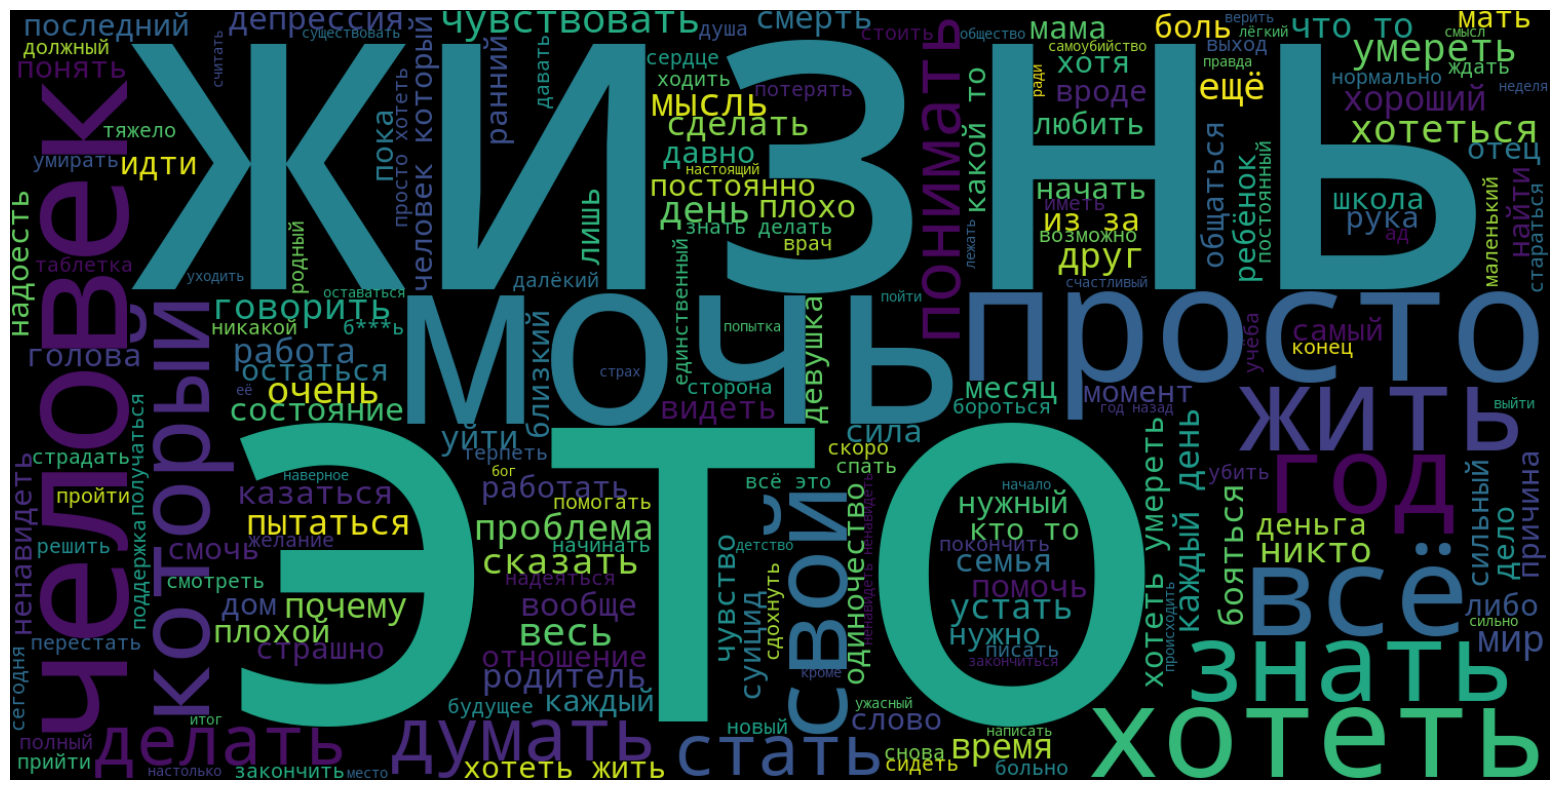

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import dirt_tongue

from string import punctuation

detector = dirt_tongue.is_dirt()
stops = stopwords.words('russian')
dataCloud = data.copy()

dataCloud['text'] = dataCloud['text'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(filter(lambda x: x not in punctuation, z)))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(filter(lambda x: x not in stops, z)))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(map(lambda x: x if not detector(x) else x[0] + ('*' * (len(x) - 2)) + x[-1], z)))

wordsCloudText = ' '.join(dataCloud[dataCloud['class'] == 1]['text'].apply(lambda x: ' '.join(x)))

print(nltk.FreqDist(wordsCloudText.split()).most_common(10))

cloud = WordCloud(width=1500, height=750, regexp=r"\w[\w*']+").generate(wordsCloudText)
plt.figure(figsize=(20, 10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("plots/cloudSuicidal.pdf", format="pdf")

[('это', 159), ('``', 90), ('...', 83), ('хотеть', 71), ('человек', 67), ('который', 64), ('просто', 46), ('всё', 44), ('б***ь', 42), ('свой', 41)]


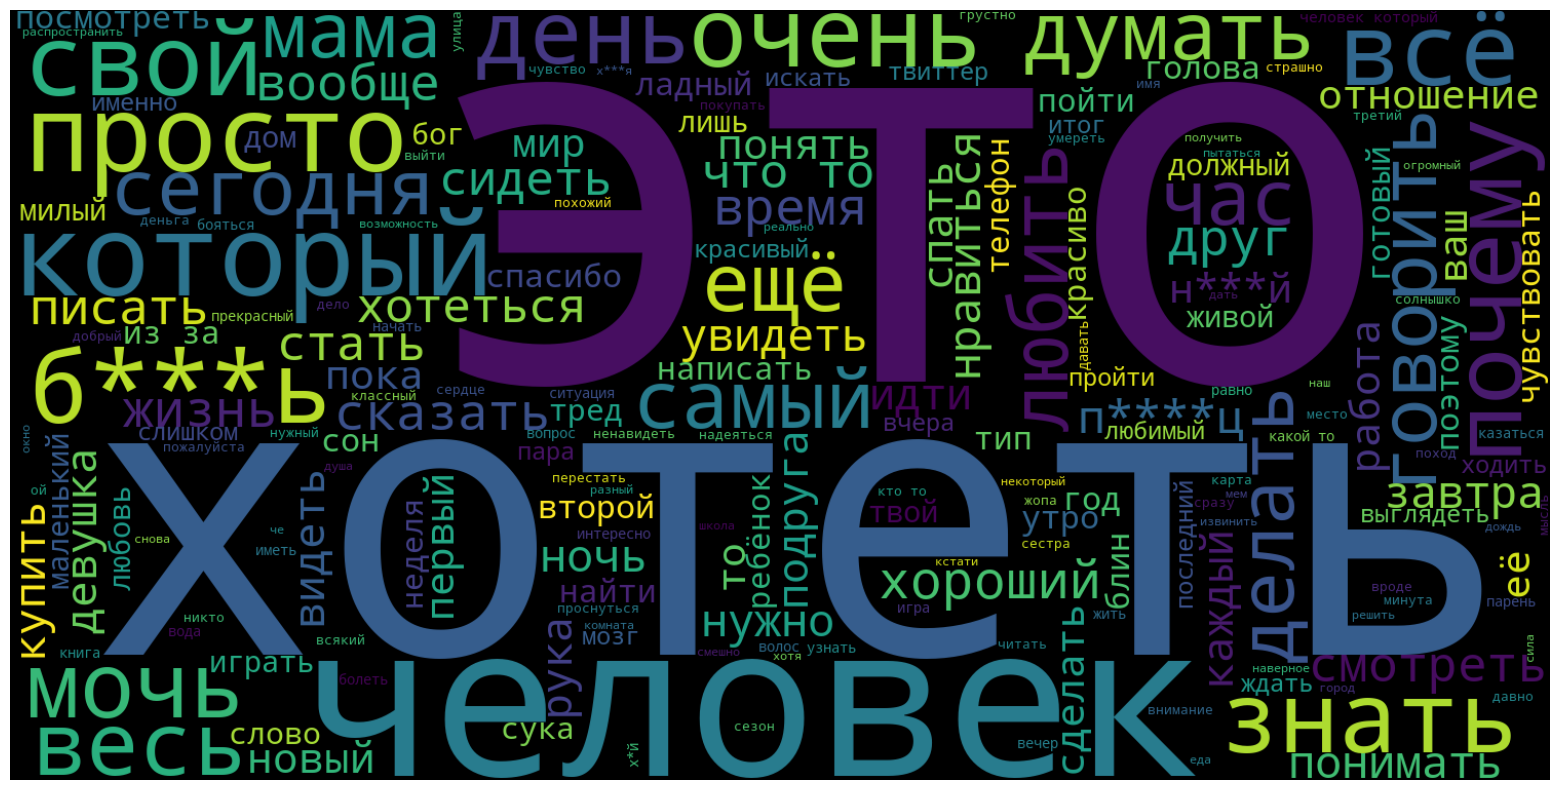

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import dirt_tongue

from string import punctuation

detector = dirt_tongue.is_dirt()
stops = stopwords.words('russian')
dataCloud = data.copy()

dataCloud['text'] = dataCloud['text'].apply(lambda x: nltk.word_tokenize(str(x).lower()))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(filter(lambda x: x not in punctuation, z)))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(filter(lambda x: x not in stops, z)))
dataCloud['text'] = dataCloud['text'].apply(lambda z: list(map(lambda x: x if not detector(x) else x[0] + ('*' * (len(x) - 2)) + x[-1], z)))

wordsCloudText = ' '.join(dataCloud[dataCloud['class'] == 0]['text'].apply(lambda x: ' '.join(x)))

print(nltk.FreqDist(wordsCloudText.split()).most_common(10))

cloud = WordCloud(width=1500, height=750, regexp=r"\w[\w*']+").generate(wordsCloudText)
plt.figure(figsize=(20, 10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("plots/cloudNonSuicidal.pdf", format="pdf")

# Сантименты

In [10]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import matplotlib.pyplot as plt

def sentimentsDiagram(to_analyze):
    tokenizer = RegexTokenizer()
    model = FastTextSocialNetworkModel(tokenizer=tokenizer)

    # Get the sentiment analysis results for the corpus
    results = model.predict(to_analyze, k=2)

    # Define a function to get the sentiment score of a message
    def get_sentiment_score(sentiment_dict):
        if 'positive' in sentiment_dict:
            return sentiment_dict['positive']
        elif 'negative' in sentiment_dict:
            return -sentiment_dict['negative']
        else:
            return 0

    # Calculate the sentiment scores for the corpus
    sentiment_scores = [get_sentiment_score(sentiment) for sentiment in results]

    # Calculate the average sentiment score
    average_sentiment = sum(sentiment_scores) / len(sentiment_scores)

    # Count the number of positive, neutral, and negative sentiments
    positive = sum(1 for score in sentiment_scores if score > 0)
    neutral = sum(1 for score in sentiment_scores if score == 0)
    negative = sum(1 for score in sentiment_scores if score < 0)

    # Create a pie chart to visualize the sentiments
    labels = ['Позитивный', 'Нейтральный', 'Отрицательный']
    sizes = [positive, neutral, negative]
    colors = ['#5cb85c', '#f0ad4e', '#d9534f']
    plt.figure(figsize=(8, 6))
    patches, texts = plt.pie(sizes, colors=colors, startangle=90)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.title('Анализ настроения\nСреднее настроение: {:.2f}'.format(average_sentiment))
    plt.savefig("plots/sentiments_suicidal.pdf", format="pdf")
    plt.show()

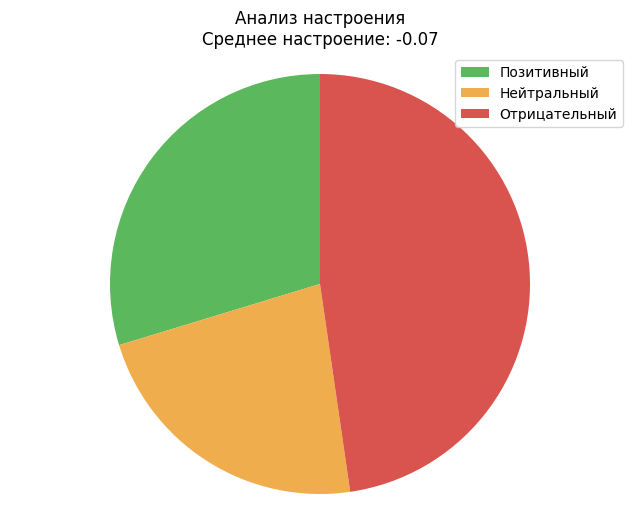

In [9]:
sentimentsDiagram(data[data['class'] == 0]['text'])

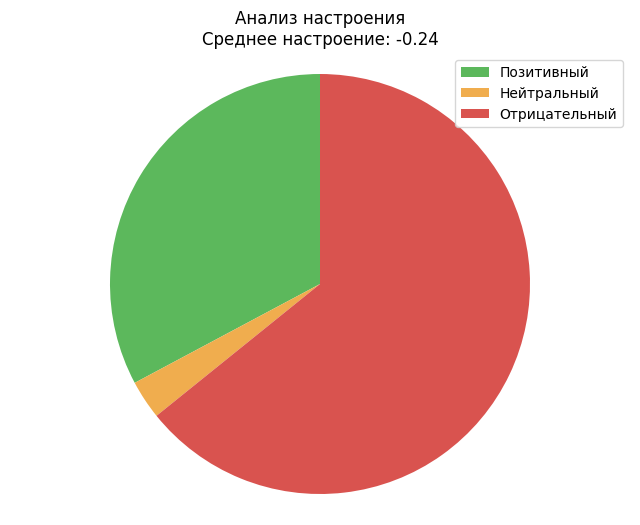

In [11]:
sentimentsDiagram(data[data['class'] == 1]['text'])

# Градиентный бустинг

## Bag

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
gridSearch(vectorized_data_bag, estimator, paramGrid={'learning_rate': [0.5], 'min_samples_split': [4, 5], 'n_estimators': [210, 215, 220]})

{'learning_rate': 0.5, 'min_samples_split': 5, 'n_estimators': 215}


Confusion matrix, without normalization
[[227  19]
 [ 54 200]]
Confusion matrix, without normalization
[[238  25]
 [ 53 184]]
Confusion matrix, without normalization
[[231  18]
 [ 55 196]]
Confusion matrix, without normalization
[[223  19]
 [ 51 207]]


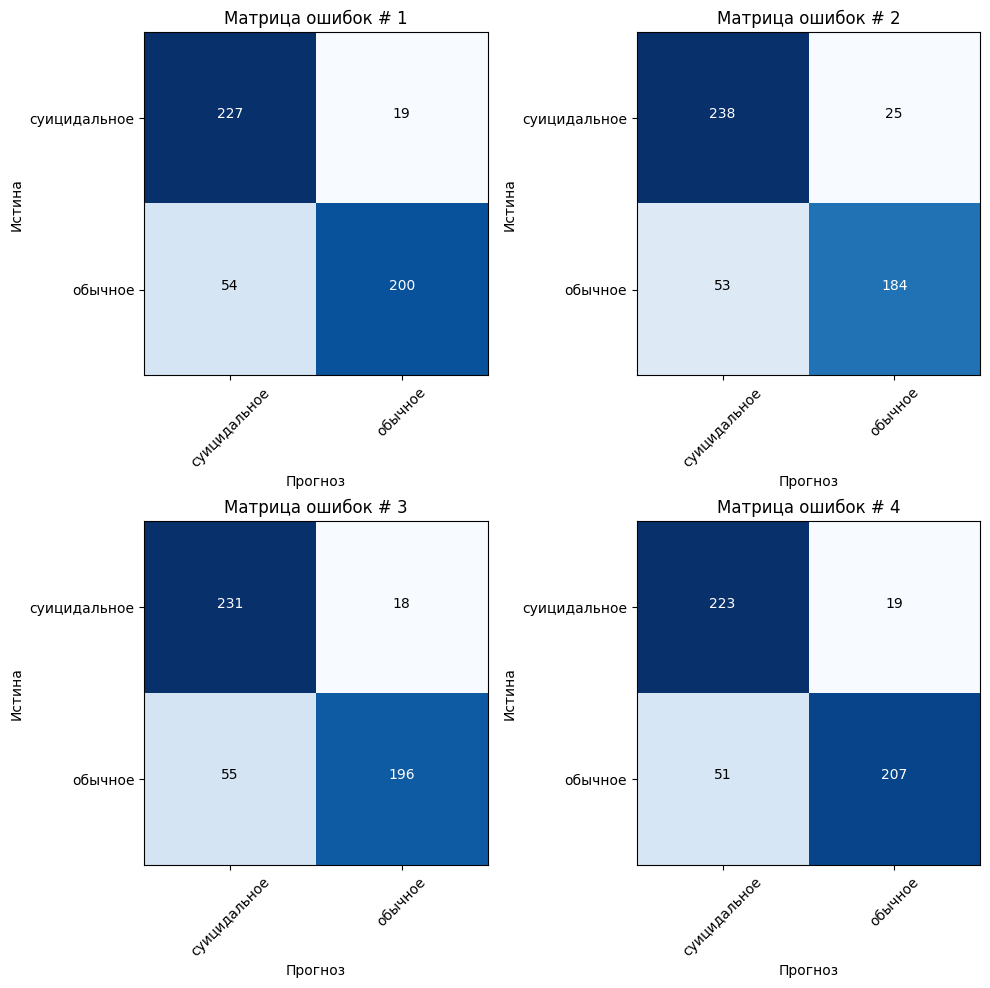

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier(learning_rate=0.5, min_samples_split=5, n_estimators=215)
confusionMatrices(vectorized_data_bag, estimator=estimator, classes=["суицидальное", "обычное"])
plt.savefig("plots/gradientMatrBag.pdf", format="pdf")

[0.854 0.84  0.86  0.858]
[0.8516129  0.83010753 0.83549784 0.85287846]
[0.927872 0.910104 0.910152 0.926616]


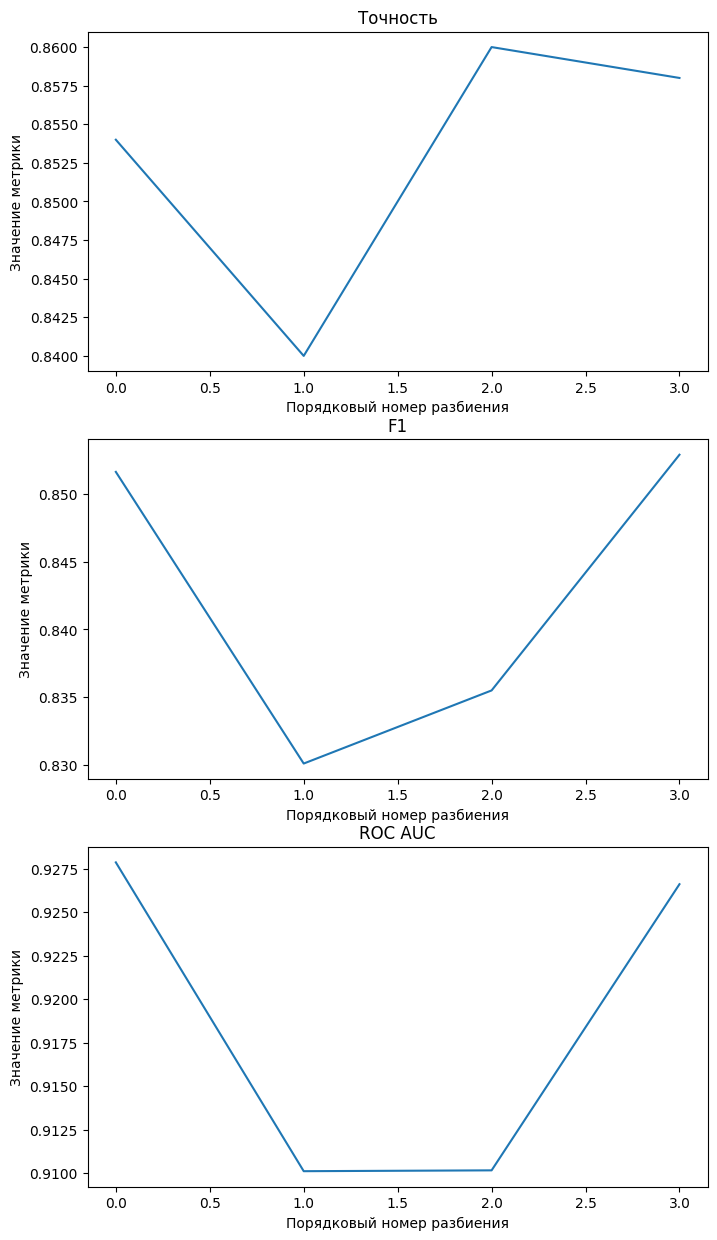

In [36]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/gradientMetricsBag.pdf", format="pdf")

In [32]:
estimator.predict(vectorizer.transform([getClearSentences("Ща сдохну от смеха")]))

array([1])

## BERT

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
gridSearch(vectorized_data_bert, estimator, paramGrid={'learning_rate': [0.3], 'min_samples_split': [16], 'n_estimators': [245]})

{'learning_rate': 0.3, 'min_samples_split': 16, 'n_estimators': 245}


Confusion matrix, without normalization
[[221  25]
 [ 50 204]]
Confusion matrix, without normalization
[[235  28]
 [ 49 188]]
Confusion matrix, without normalization
[[231  18]
 [ 54 197]]
Confusion matrix, without normalization
[[225  17]
 [ 46 212]]


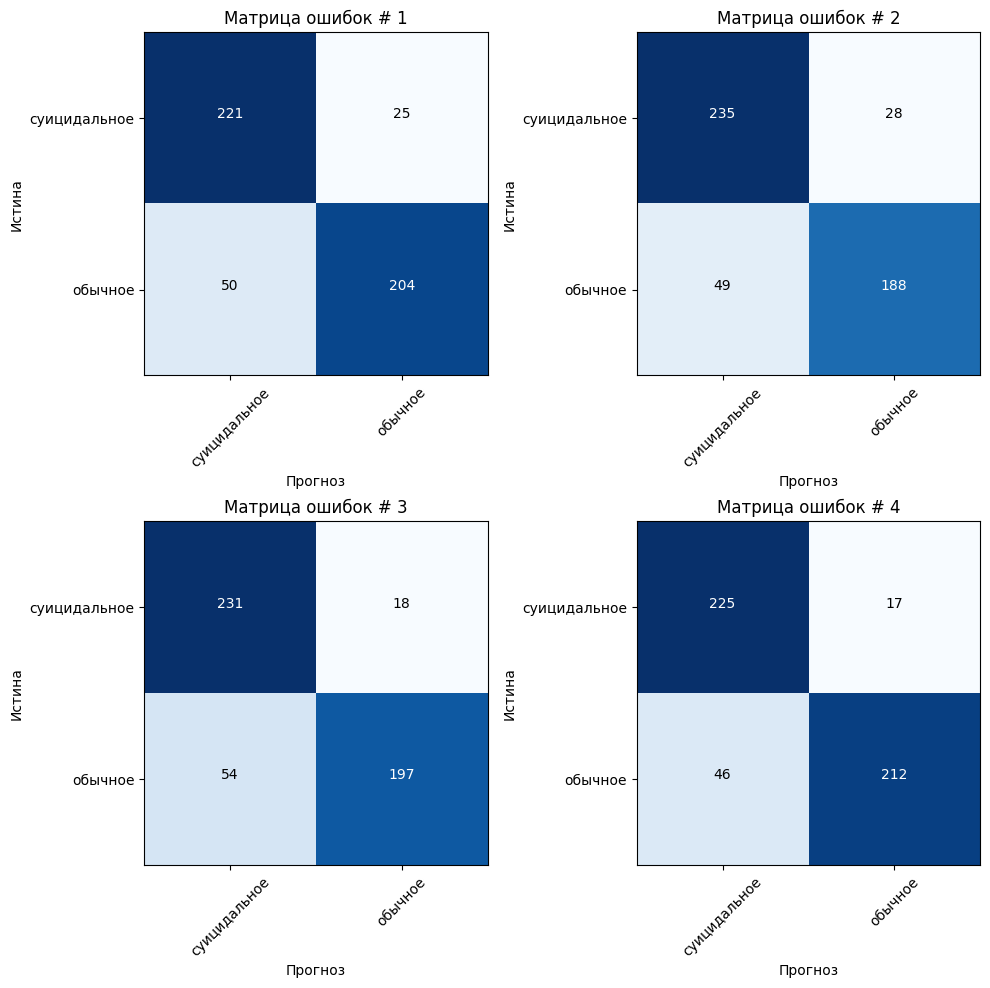

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier(learning_rate=0.3, min_samples_split=16, n_estimators=245)
confusionMatrices(vectorized_data_bert, estimator=estimator, classes=["суицидальное", "обычное"])
plt.savefig("plots/gradientMatrBert.pdf", format="pdf")

[0.852 0.848 0.856 0.89 ]
[0.84759916 0.83050847 0.84861407 0.87815126]
[0.935896 0.91572  0.926408 0.939376]


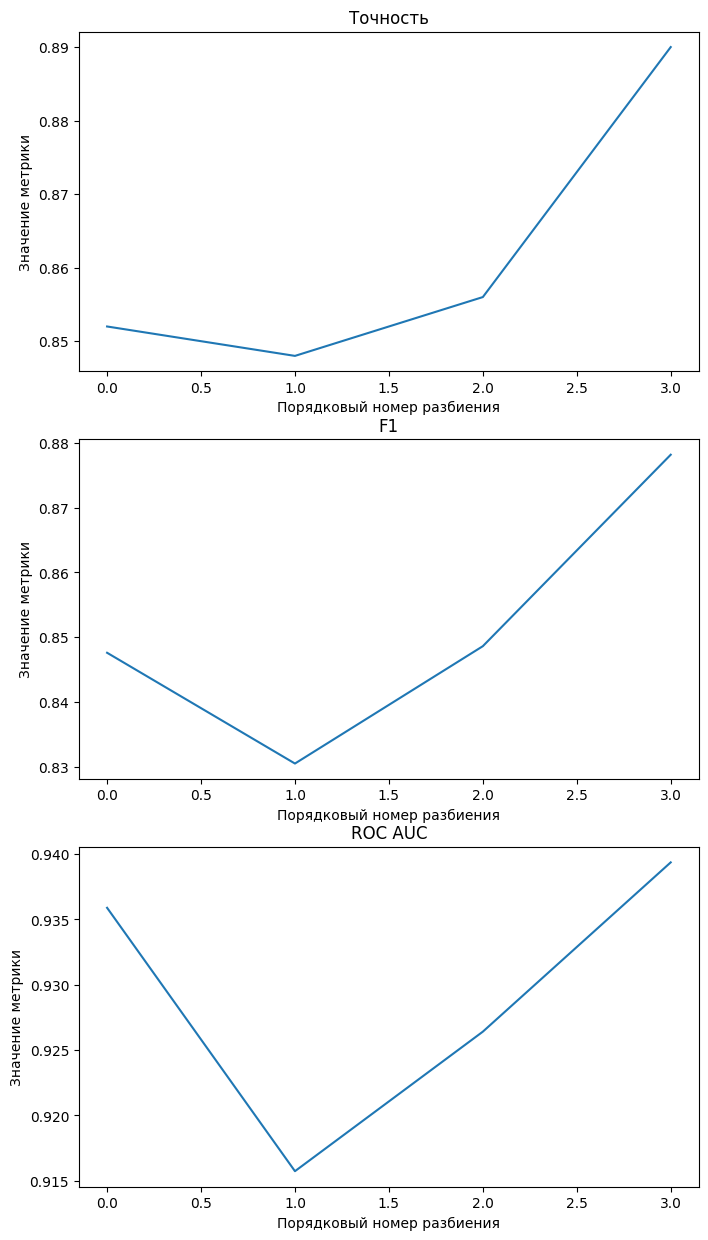

In [38]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/gradientMetricsBert.pdf", format="pdf")

In [ ]:
estimator.predict(vectorizer.transform([getClearSentences("Ща сдохну от смеха")]))

# Random Forest

## Bag

In [14]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
gridSearch(vectorized_data_bag, estimator, paramGrid={'n_jobs': [-1],'n_estimators': [850, 900, 950], 'max_depth':[300, None], 'max_features': ['sqrt', 'log2', None]})

{'max_depth': 300, 'max_features': 'log2', 'n_estimators': 900, 'n_jobs': -1}


Confusion matrix, without normalization
[[230  16]
 [ 43 211]]
Confusion matrix, without normalization
[[239  24]
 [ 43 194]]
Confusion matrix, without normalization
[[235  14]
 [ 44 207]]
Confusion matrix, without normalization
[[229  13]
 [ 43 215]]


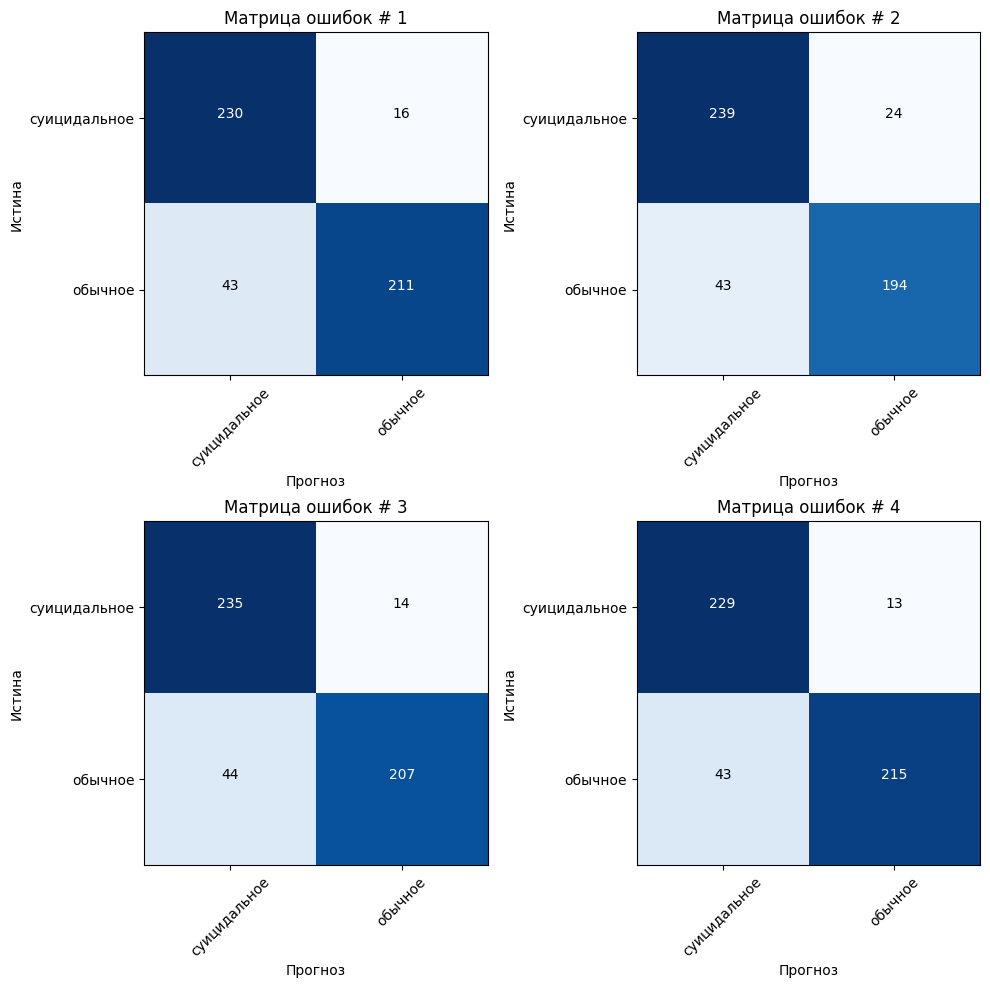

In [39]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_depth=300, max_features='log2', n_estimators=850, n_jobs=-1)
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/randomMatrBag.pdf", format="pdf")

[0.876 0.862 0.89  0.882]
[0.87526427 0.86847599 0.87931034 0.87898089]
[0.951744 0.940128 0.937664 0.957416]


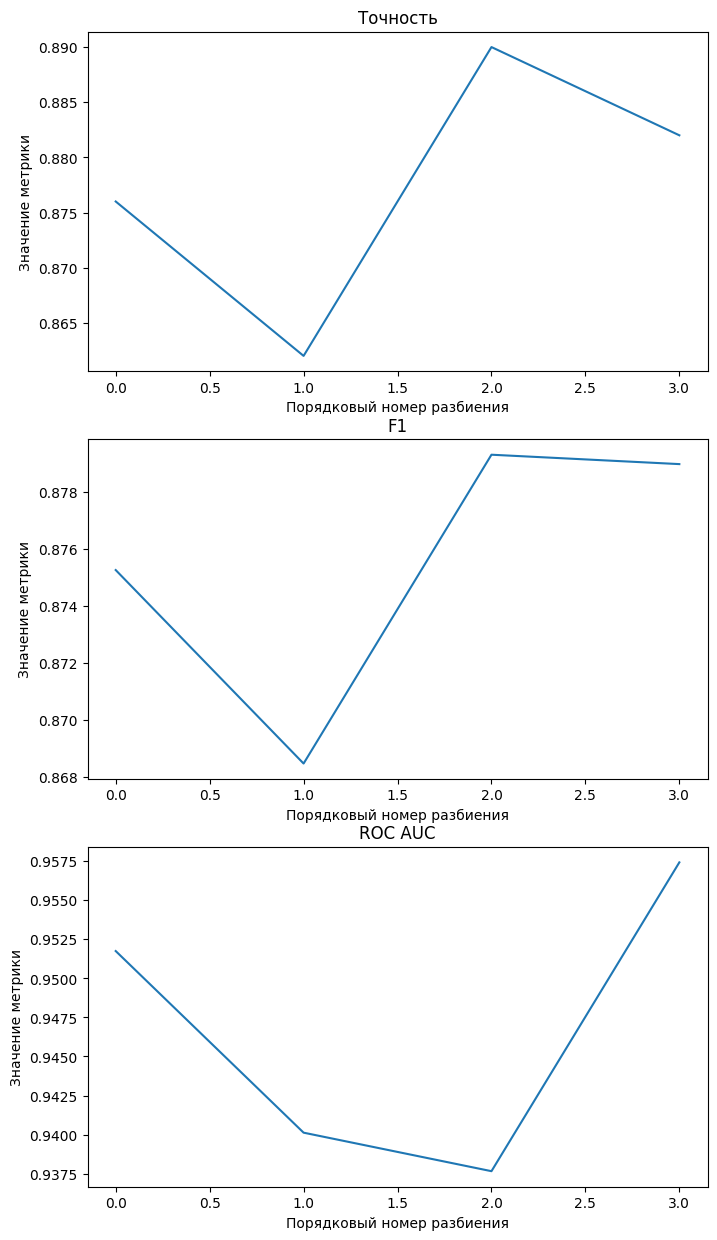

In [40]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/randomMetricsBag.pdf", format="pdf")

## BERT

In [11]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
gridSearch(vectorized_data_bert, estimator, paramGrid={'n_jobs': [-1],'n_estimators': [2550, 2600, 2650], 'max_depth':[None], 'max_features': ['log2']})

{'max_depth': None, 'max_features': 'log2', 'n_estimators': 2600, 'n_jobs': -1}


In [7]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_features='log2', n_estimators=2600, n_jobs=-1) #wolol, мне кажется, нужно добить исследование по количеству решателей и будет очень крутой результат...
plt.figure(figsize=(20, 10))
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/randomMatrBert.pdf", format="pdf")

In [8]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/randomMetricsBert.pdf", format="pdf")

In [8]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(max_features='log2', n_estimators=2600, n_jobs=-1)
estimator.fit(vectorized_data_bert, data['class'].apply(lambda x: int(x)))

RandomForestClassifier(max_features='log2', n_estimators=2600, n_jobs=-1)

In [32]:
temp_corp = corpus.append(pd.Series([getClearSentences("хочу напиться вусмерть")]))

bert_tokenized = temp_corp.apply(lambda ser: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ser)))
bert_list = bert_tokenized.tolist()

nRows = len(bert_list)
nCols = max(max(row) if (len(row) > 0) else 0 for row in bert_list) + 1

dataIn = []
indices = []
indptr = [0]

for row in bert_list:
    indices.extend(row)
    dataIn.extend([1] * len(row))
    indptr.append(len(indices))

vectorized_temp = csr_matrix((dataIn, indices, indptr), shape=(nRows, nCols))
estimator.predict(vectorized_temp[-1:])

/var/folders/nd/rxp2phv12xl4m1wk92ksqgxr0000gn/T/ipykernel_940/697000083.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_corp = corpus.append(pd.Series([getClearSentences("хочу напиться вусмерть")]))


array([1])

# SVC

## Bag

In [43]:
from sklearn.svm import SVC

estimator = SVC()
gridSearch(vectorized_data_bag, estimator, paramGrid={'C': [7.0], 'degree': [2, 3, 4, 6, 7], 'kernel': ['linear', 'poly', 'rbf']})

{'C': 7.0, 'degree': 2, 'kernel': 'rbf'}


Confusion matrix, without normalization
[[206  40]
 [ 37 217]]
Confusion matrix, without normalization
[[225  38]
 [ 39 198]]
Confusion matrix, without normalization
[[210  39]
 [ 50 201]]
Confusion matrix, without normalization
[[214  28]
 [ 37 221]]


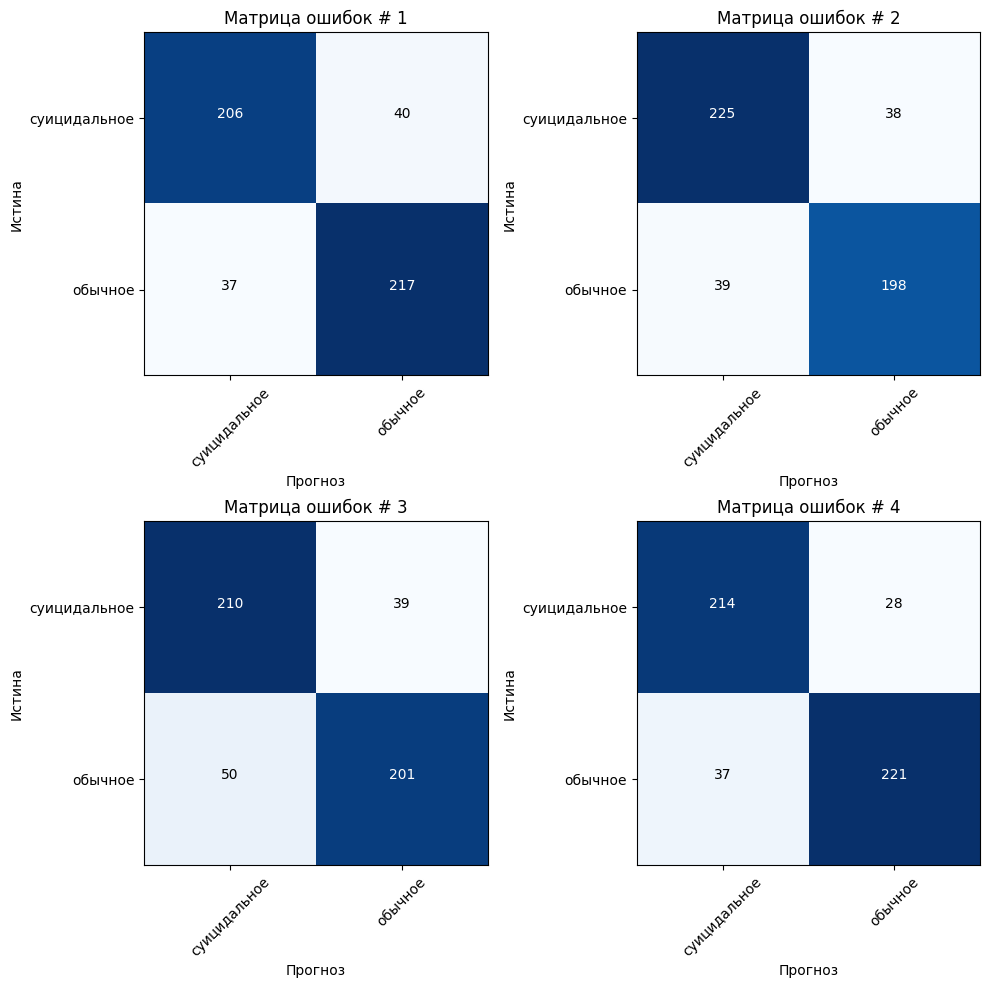

In [44]:
estimator = SVC(C=7.0, degree=2, kernel='linear')
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/svcMatrBag.pdf", format="pdf")

[0.85  0.848 0.824 0.864]
[0.85089463 0.84677419 0.81893004 0.86178862]
[0.92424  0.919904 0.898576 0.91788 ]


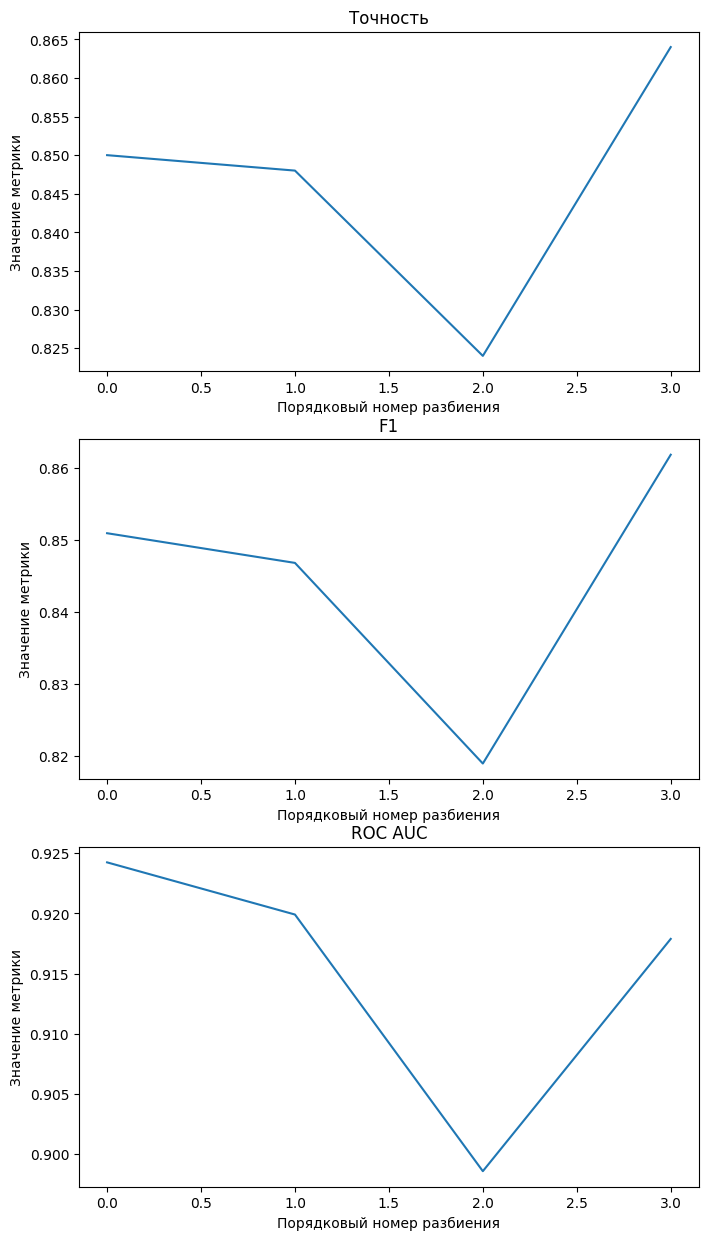

In [45]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/svcMetricsBag.pdf", format="pdf")

## BERT

In [41]:
from sklearn.svm import SVC

estimator = SVC()
gridSearch(vectorized_data_bert, estimator, paramGrid={'C': [1.5, 2.0, 2.5], 'degree': [2, 3, 4, 5, 6, 7], 'kernel': ['linear', 'poly', 'rbf']})

{'C': 1.5, 'degree': 2, 'kernel': 'linear'}


Confusion matrix, without normalization
[[211  35]
 [ 33 221]]
Confusion matrix, without normalization
[[226  37]
 [ 34 203]]
Confusion matrix, without normalization
[[215  34]
 [ 42 209]]
Confusion matrix, without normalization
[[219  23]
 [ 32 226]]


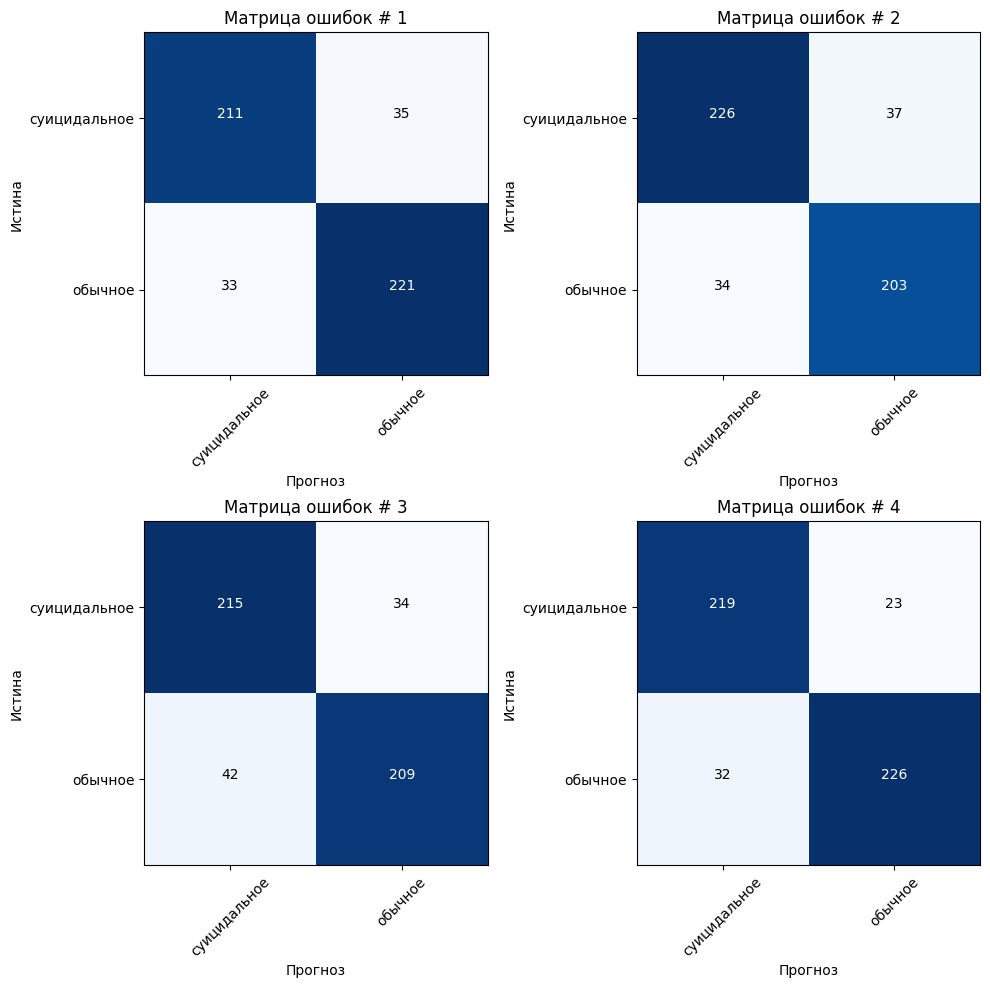

In [46]:
estimator = SVC(C=1.5, degree=2, kernel='linear')
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/svcMatrBert.pdf", format="pdf")

[0.864 0.85  0.848 0.886]
[0.86507937 0.8502994  0.8442623  0.88438134]
[0.930368 0.92096  0.919352 0.928432]


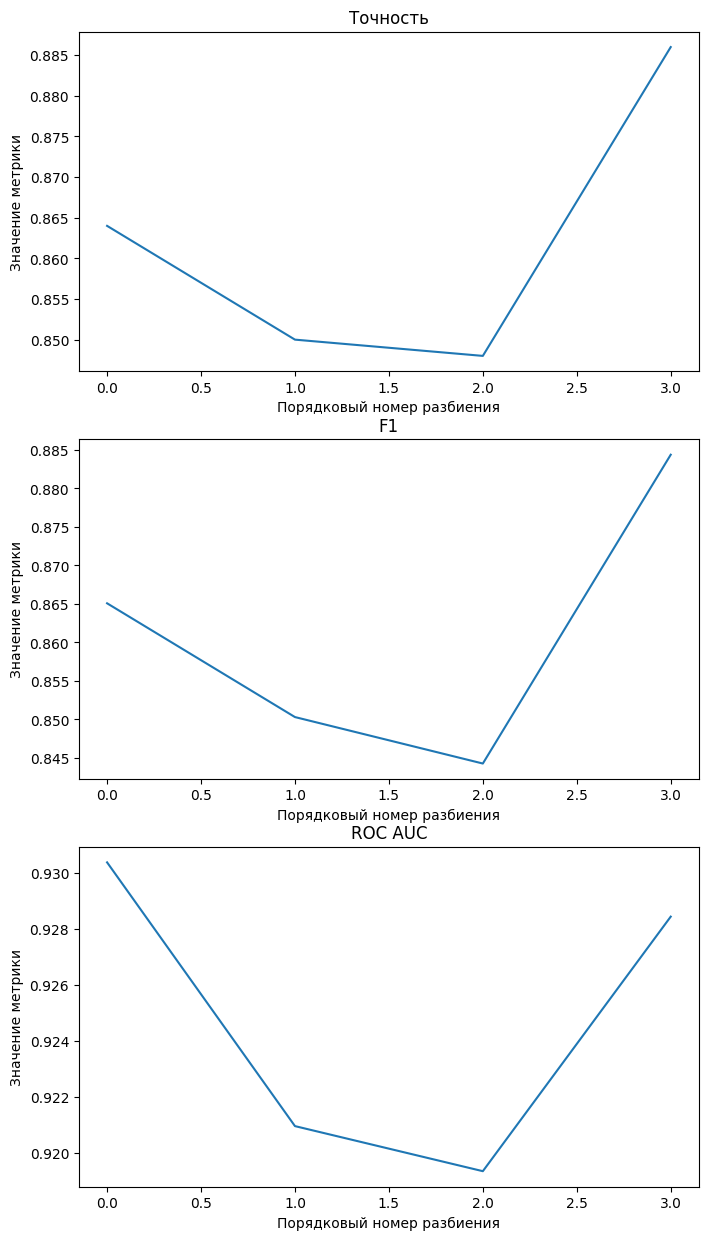

In [47]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/svcMetricsBert.pdf", format="pdf")

# KNN

## Bag

In [49]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
print(gridSearch(vectorized_data_bag, estimator, paramGrid={'n_neighbors': [5, 6, 7], 'weights': ['uniform', 'distance'], 'leaf_size': [4, 5, 6], 'p': [1], 'metric': ['euclidean', 'manhattan']}))

{'leaf_size': 4, 'metric': 'euclidean', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
None


Confusion matrix, without normalization
[[230  16]
 [117 137]]
Confusion matrix, without normalization
[[241  22]
 [102 135]]
Confusion matrix, without normalization
[[234  15]
 [111 140]]
Confusion matrix, without normalization
[[213  29]
 [ 77 181]]


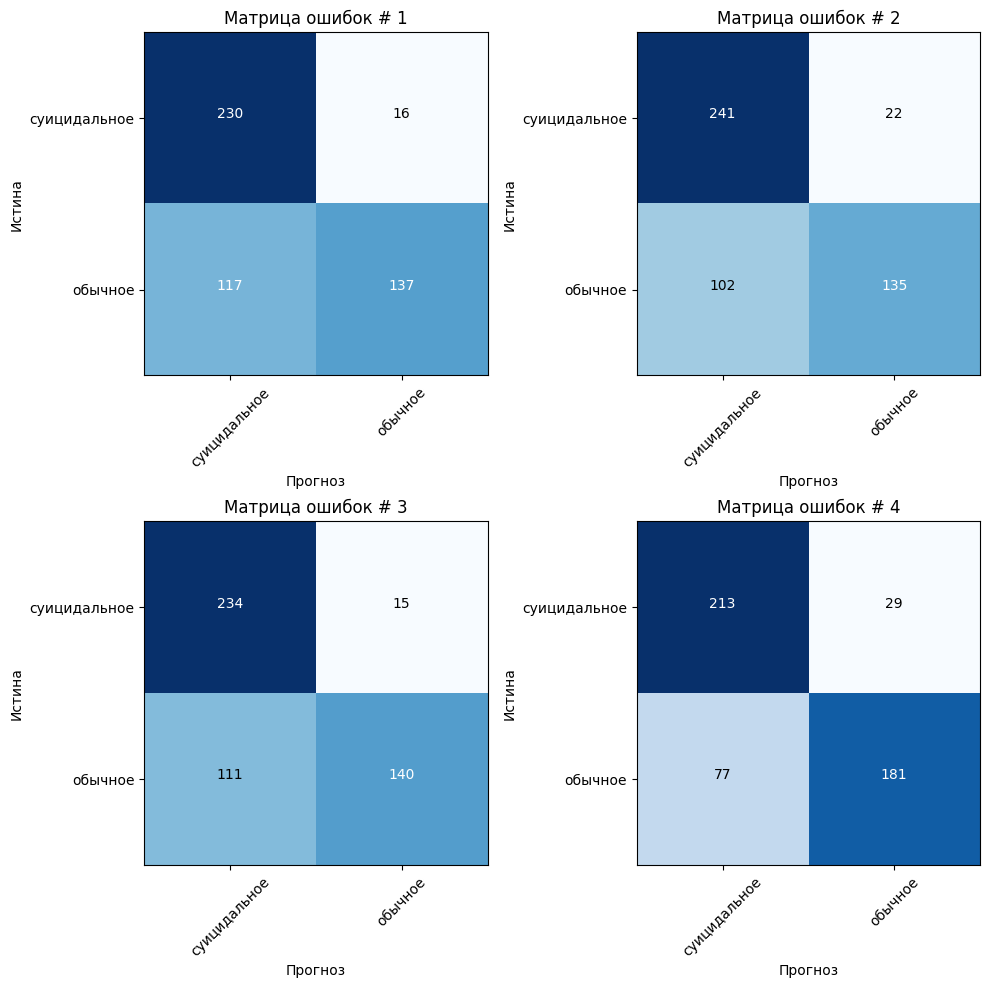

In [50]:
estimator = KNeighborsClassifier(n_neighbors=5, weights='distance', leaf_size=4, p=1, metric='euclidean')
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/knnMatrBag.pdf", format="pdf")

[0.742 0.75  0.738 0.778]
[0.69212411 0.69135802 0.67813268 0.75388027]
[0.854112 0.844424 0.845    0.873632]


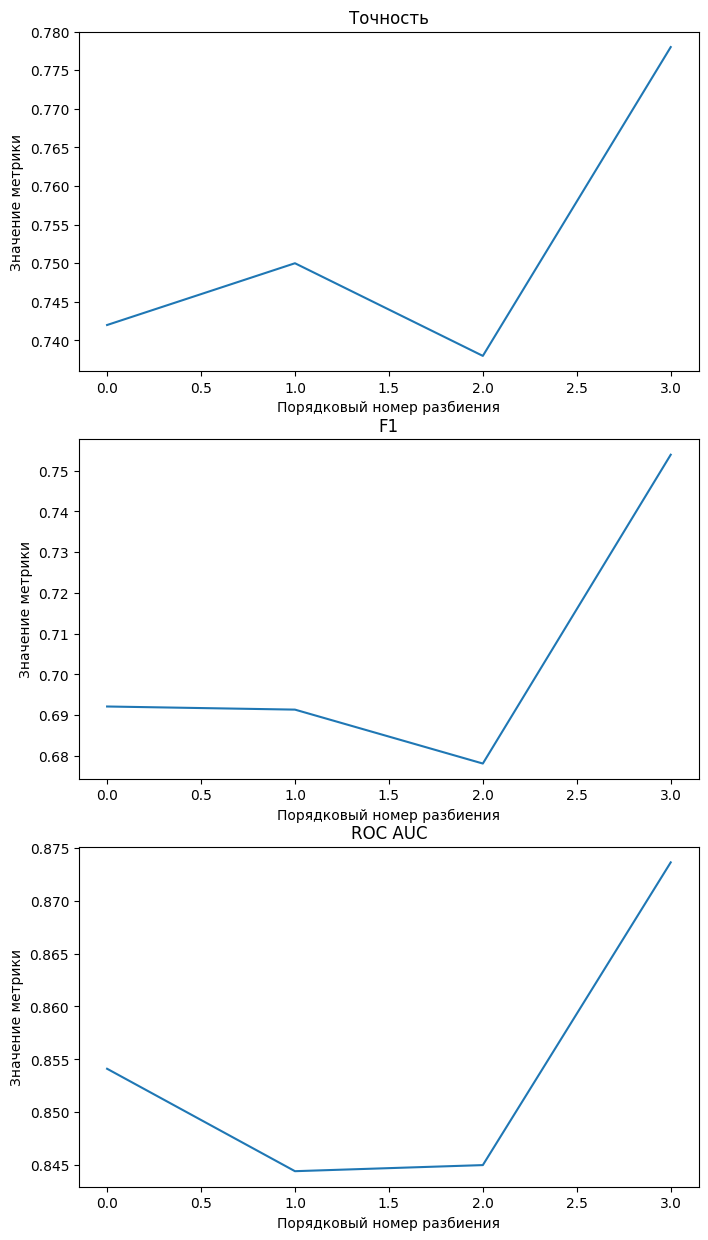

In [51]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/knnMetricsBag.pdf", format="pdf")

## BERT

In [50]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
print(gridSearch(vectorized_data_bert, estimator, paramGrid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 'weights': ['uniform', 'distance'], 'leaf_size': [1, 2, 3, 4, 5], 'p': [1, 2, 3, 4, 5], 'metric': ['euclidean', 'manhattan']}))

{'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
None


Confusion matrix, without normalization
[[213  33]
 [ 81 173]]
Confusion matrix, without normalization
[[219  44]
 [ 76 161]]
Confusion matrix, without normalization
[[203  46]
 [ 84 167]]
Confusion matrix, without normalization
[[200  42]
 [ 73 185]]


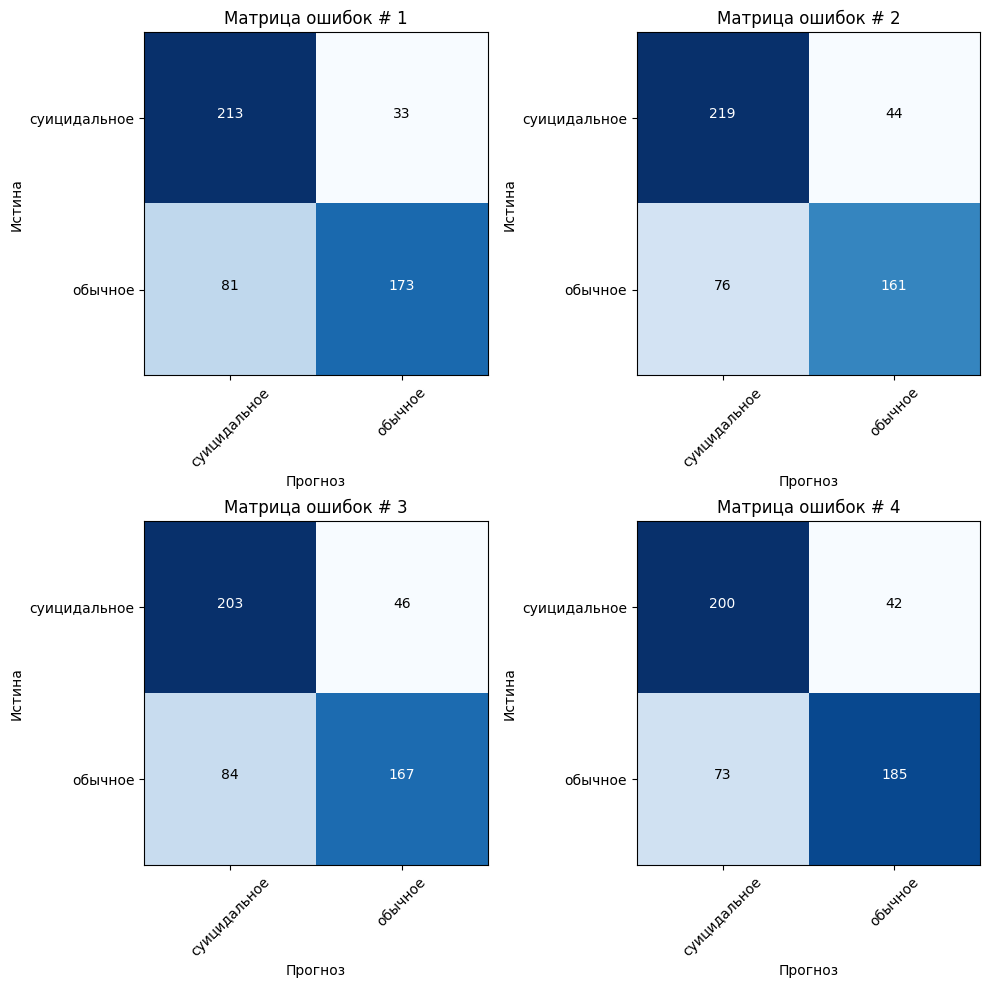

In [52]:
estimator = KNeighborsClassifier(n_neighbors=6, weights='distance', leaf_size=1, p=1, metric='euclidean')
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/knnMatrBert.pdf", format="pdf")

[0.772 0.762 0.72  0.778]
[0.74889868 0.73960613 0.69565217 0.76129032]
[0.868296 0.830632 0.815752 0.853216]


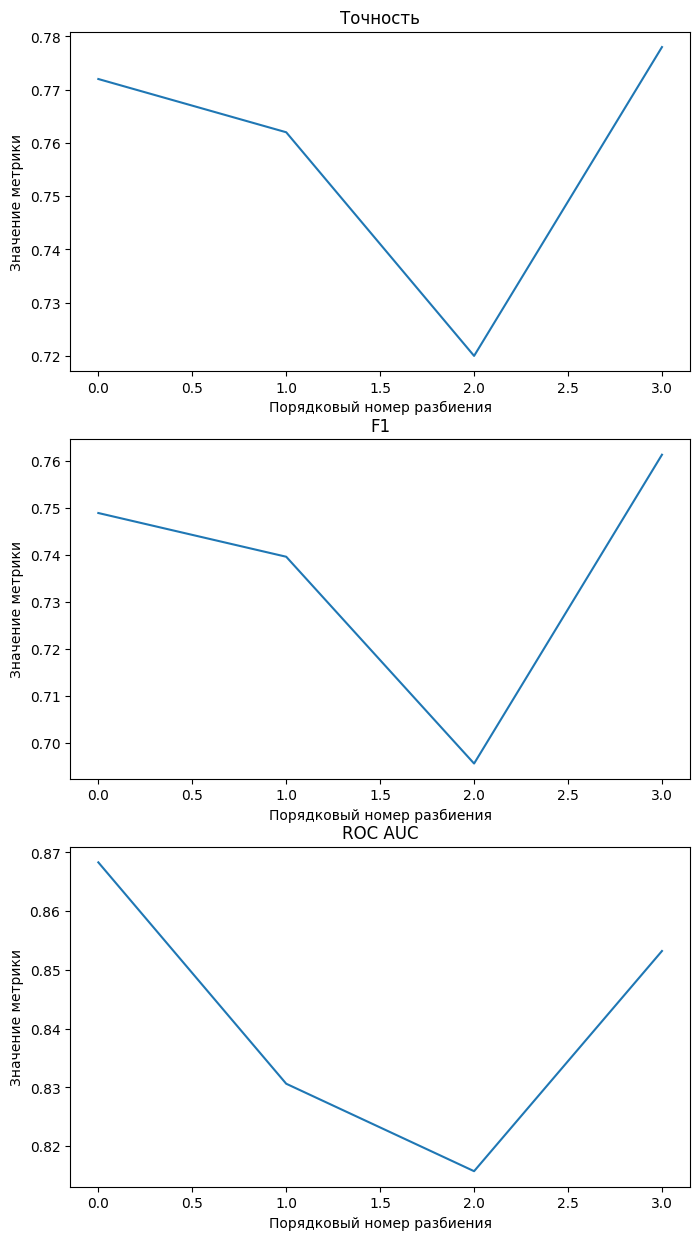

In [53]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/knnMetricsBert.pdf", format="pdf")

# Logistic Regression

## Bag

In [56]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
gridSearch(vectorized_data_bag, estimator, paramGrid={'penalty': ['l2'], 'C': [2.1, 2.2, 2.3, 2.4], 'class_weight': [{0: 1, 1: 2}, {0: 2, 1: 1}, 'balanced', None], 'solver': ['lbfgs', 'liblinear', 'newton-ct']})

{'C': 2.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'liblinear'}


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.11/site-packages

Confusion matrix, without normalization
[[225  21]
 [ 45 209]]
Confusion matrix, without normalization
[[239  24]
 [ 45 192]]
Confusion matrix, without normalization
[[231  18]
 [ 50 201]]
Confusion matrix, without normalization
[[226  16]
 [ 47 211]]


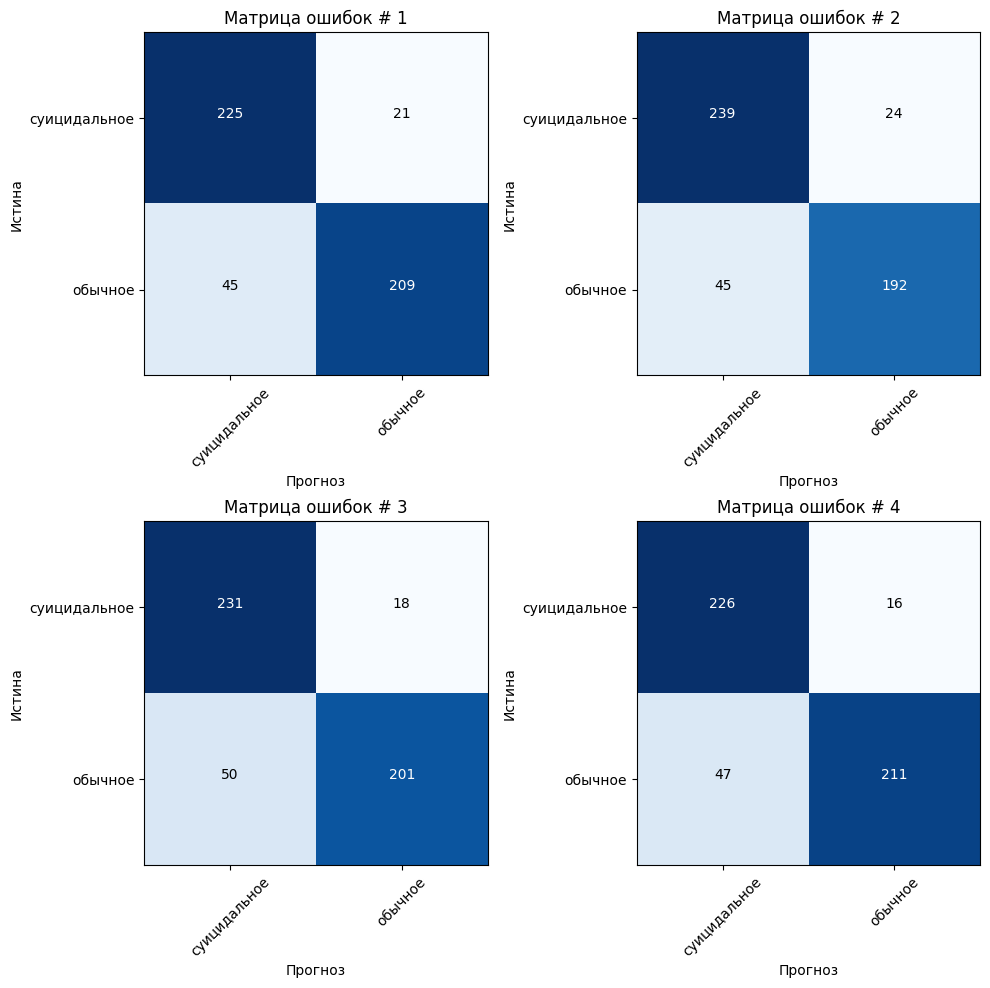

In [57]:
estimator = LogisticRegression(penalty='l2', C= 2.2, class_weight='balanced', solver='liblinear')
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/logicMatrBag.pdf", format="pdf")

[0.864 0.86  0.862 0.88 ]
[0.85833333 0.85294118 0.85097192 0.87234043]
[0.947368 0.938656 0.925984 0.935528]


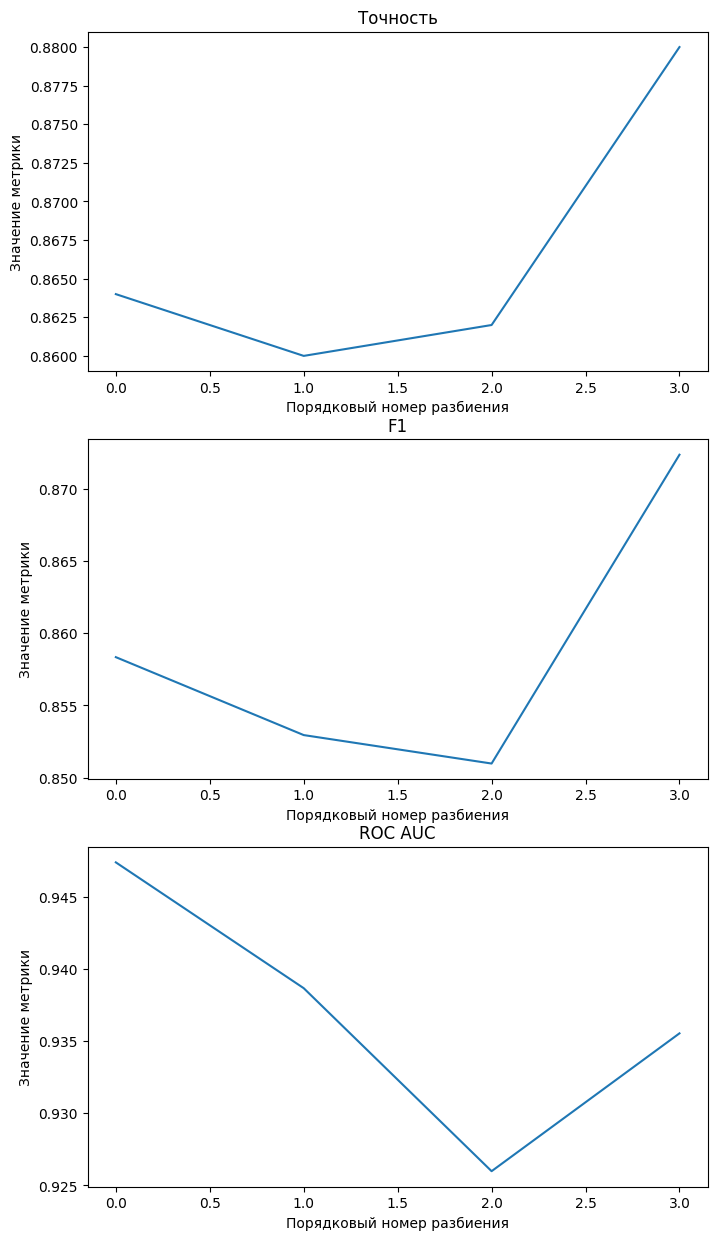

In [58]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/logicMetricsBag.pdf", format="pdf")

## BERT

In [58]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
gridSearch(vectorized_data_bert, estimator, paramGrid={'penalty': ['l2'], 'C': [2.1, 2.2, 2.3, 2.4], 'class_weight': [{0: 1, 1: 2}, {0: 2, 1: 1}, 'balanced', None], 'solver': ['liblinear', 'newton-ct']})

{'C': 2.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.11/site-packages/

Confusion matrix, without normalization
[[222  24]
 [ 36 218]]
Confusion matrix, without normalization
[[235  28]
 [ 42 195]]
Confusion matrix, without normalization
[[228  21]
 [ 45 206]]
Confusion matrix, without normalization
[[225  17]
 [ 36 222]]


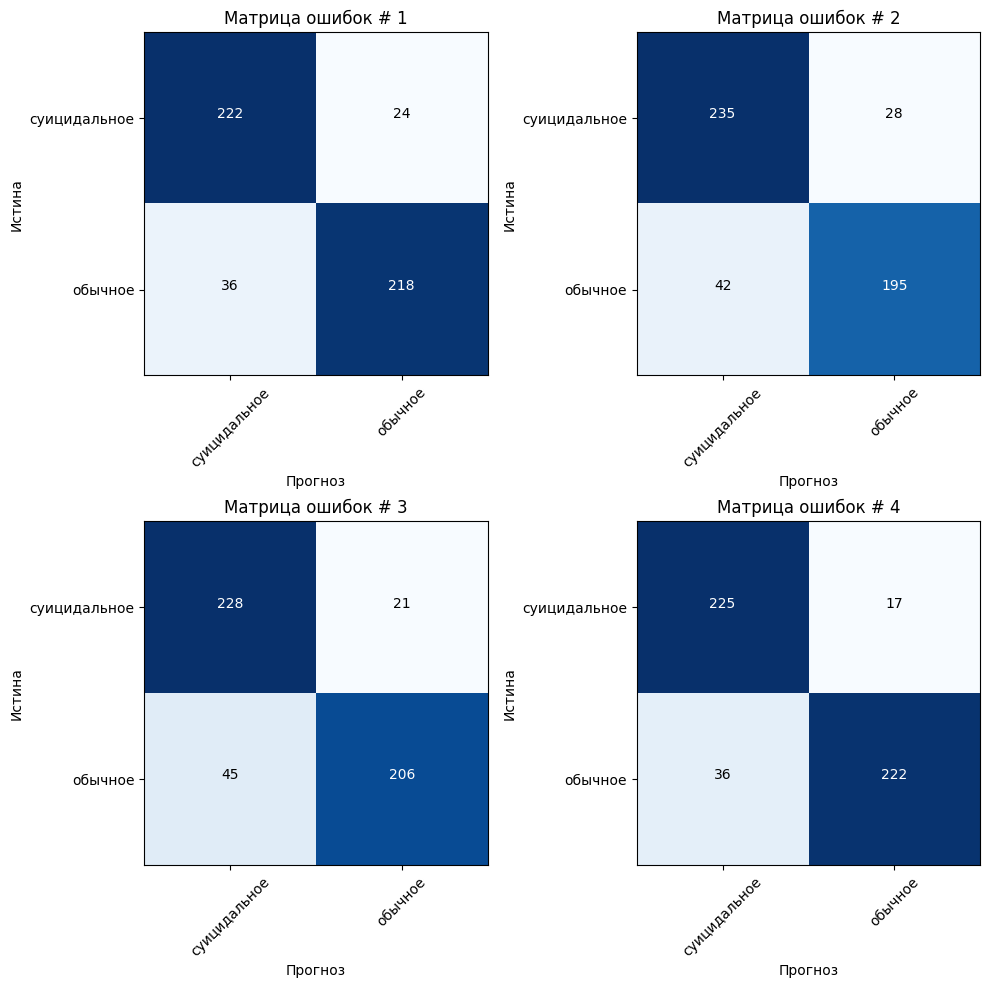

In [59]:
estimator = LogisticRegression(penalty='l2', C= 2.1, class_weight='balanced', solver='liblinear')
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/logicMatrBert.pdf", format="pdf")

[0.882 0.854 0.866 0.892]
[0.8793456  0.84886128 0.85774947 0.8879668 ]
[0.950784 0.941488 0.931136 0.943856]


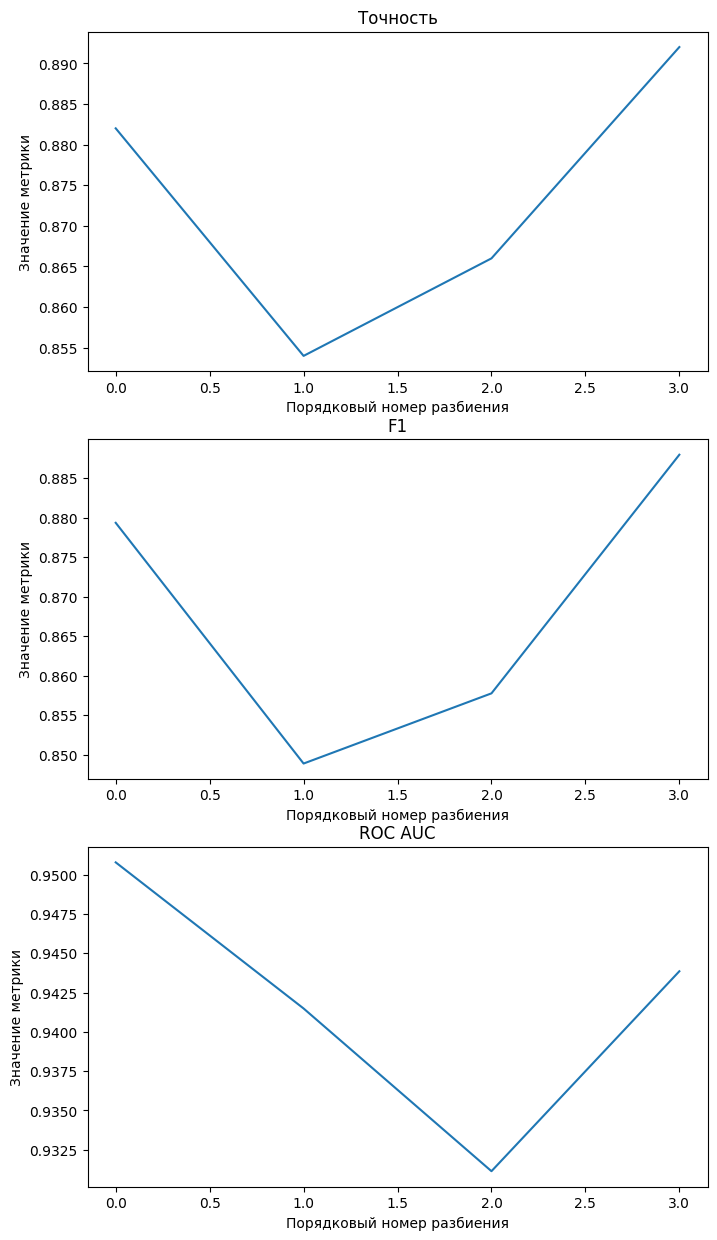

In [60]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/logicMetricsBert.pdf", format="pdf")

# Perceptron

## Bag

In [61]:
from sklearn.linear_model import Perceptron

estimator = Perceptron()
gridSearch(vectorized_data_bag, estimator, paramGrid={'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.0005, 0.001], 'n_jobs': [-1], 'max_iter': [30], 'class_weight': [{0:1, 1:2}, {0:2, 1:1}, 'balanced', None]})

{'alpha': 0.0001, 'class_weight': {0: 2, 1: 1}, 'max_iter': 30, 'n_jobs': -1, 'penalty': 'l1'}


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Confusion matrix, without normalization
[[212  34]
 [ 35 219]]
Confusion matrix, without normalization
[[207  56]
 [ 35 202]]
Confusion matrix, without normalization
[[203  46]
 [ 38 213]]
Confusion matrix, without normalization
[[214  28]
 [ 49 209]]


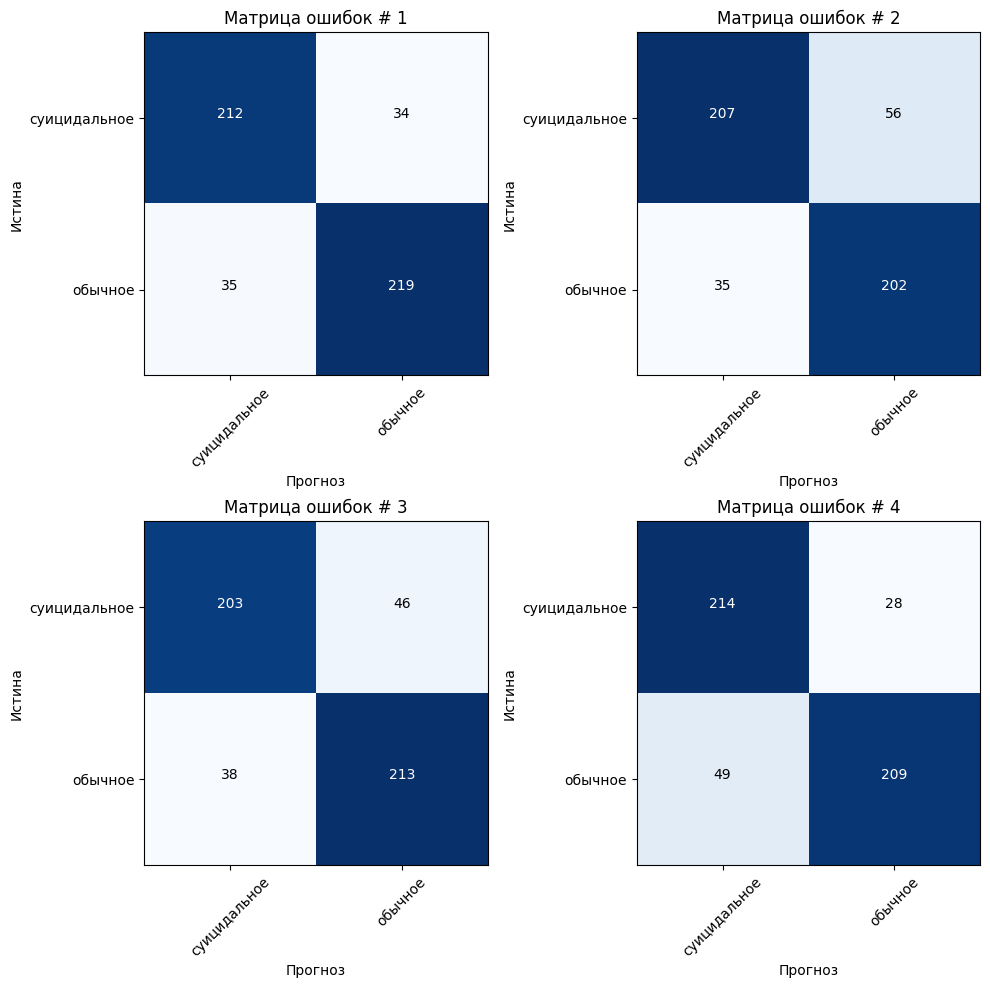

In [62]:
estimator = Perceptron(alpha=0.0001, class_weight=None, max_iter=30, penalty='l1', n_jobs=-1)
confusionMatrices(vectorized_data_bag, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/perceptronMatrBag.pdf", format="pdf")

[0.868 0.828 0.828 0.826]
[0.87109375 0.83268482 0.83070866 0.82703777]
[0.930552 0.913168 0.89552  0.90904 ]


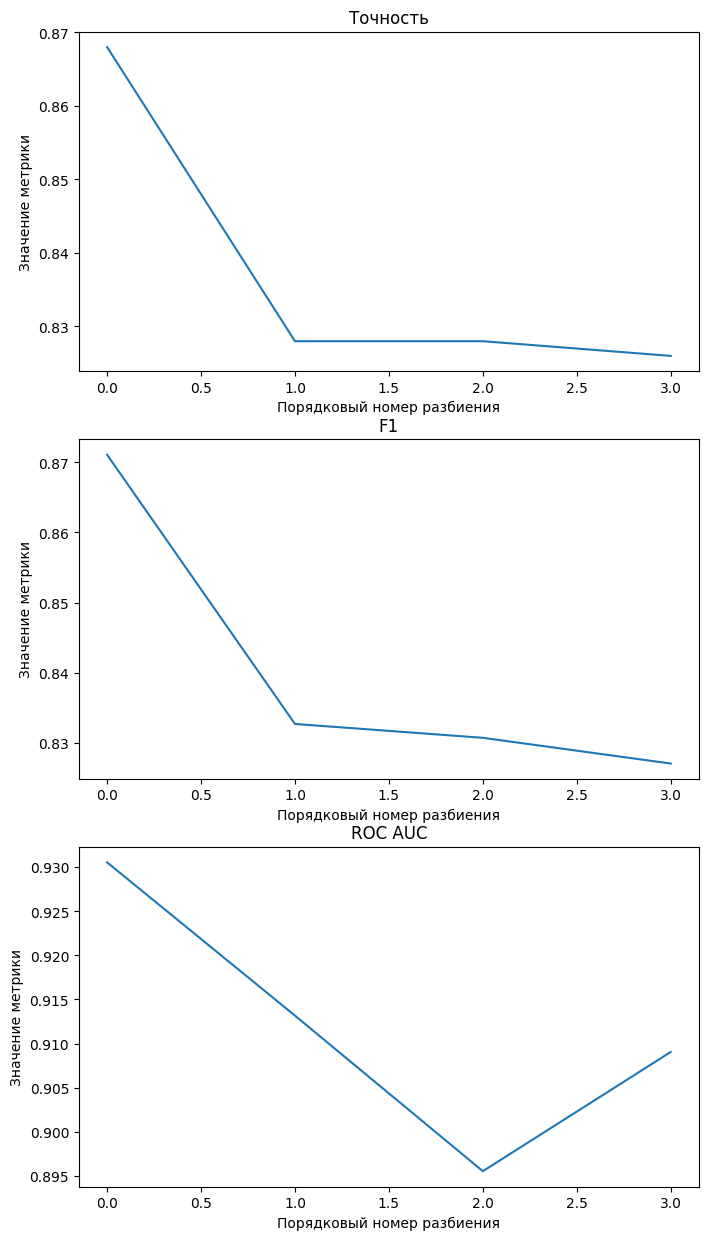

In [63]:
crossScores(vectorized_data_bag, estimator)
plt.savefig("plots/perceptronMetricsBag.pdf", format="pdf")

## BERT

In [64]:
from sklearn.linear_model import Perceptron

estimator = Perceptron()
gridSearch(vectorized_data_bert, estimator, paramGrid={'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.0005, 0.001], 'n_jobs': [-1], 'max_iter': [30, 40, 50, 60, 100, 200, 300, 400], 'class_weight': [{0:1, 1:2}, {0:2, 1:1}, 'balanced', None]})

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'alpha': 0.0001, 'class_weight': {0: 1, 1: 2}, 'max_iter': 30, 'n_jobs': -1, 'penalty': 'l1'}


Confusion matrix, without normalization
[[189  57]
 [ 18 236]]
Confusion matrix, without normalization
[[217  46]
 [ 36 201]]
Confusion matrix, without normalization
[[207  42]
 [ 38 213]]
Confusion matrix, without normalization
[[203  39]
 [ 25 233]]


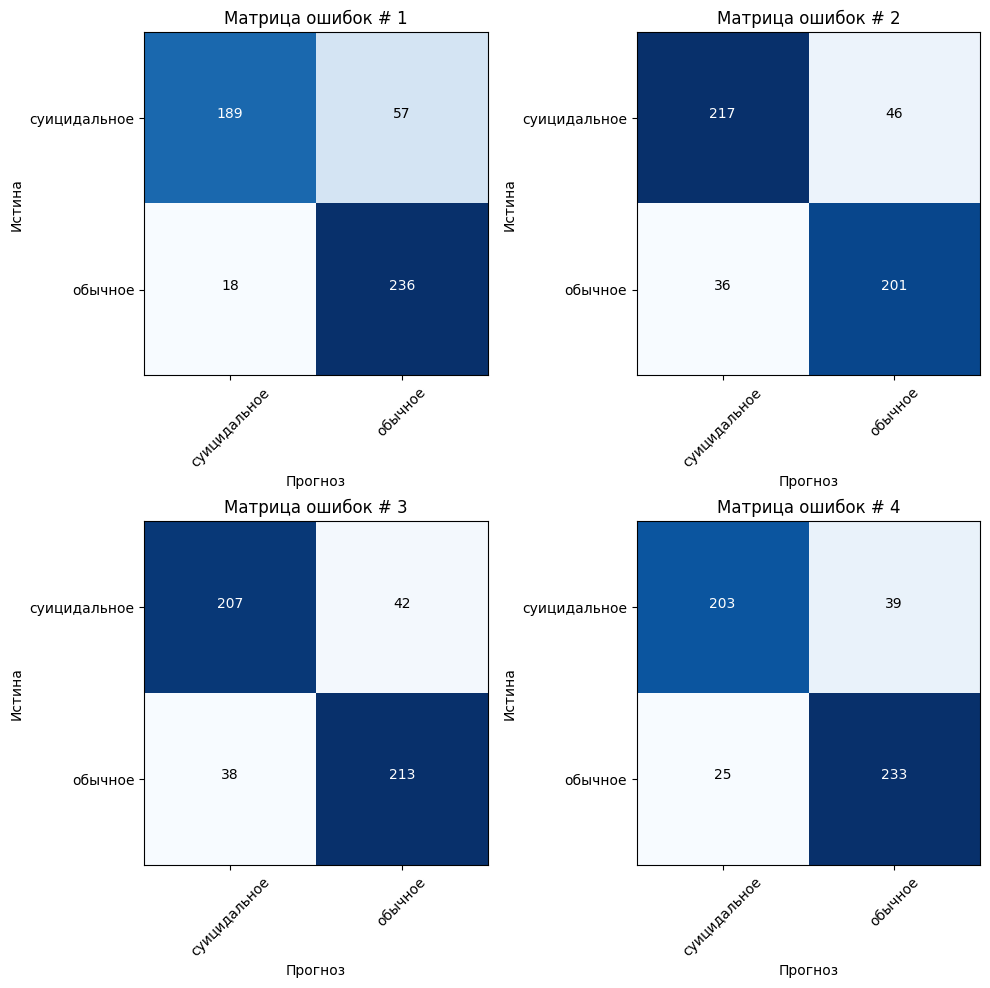

In [65]:
estimator = Perceptron(alpha=0.0001, class_weight=None, max_iter=30, penalty='l1', n_jobs=-1)
confusionMatrices(vectorized_data_bert, estimator, ["суицидальное", "обычное"])
plt.savefig("plots/perceptronMatrBert.pdf", format="pdf")

[0.87  0.826 0.848 0.868]
[0.87329435 0.83172147 0.84980237 0.87209302]
[0.93876  0.921968 0.925336 0.937552]


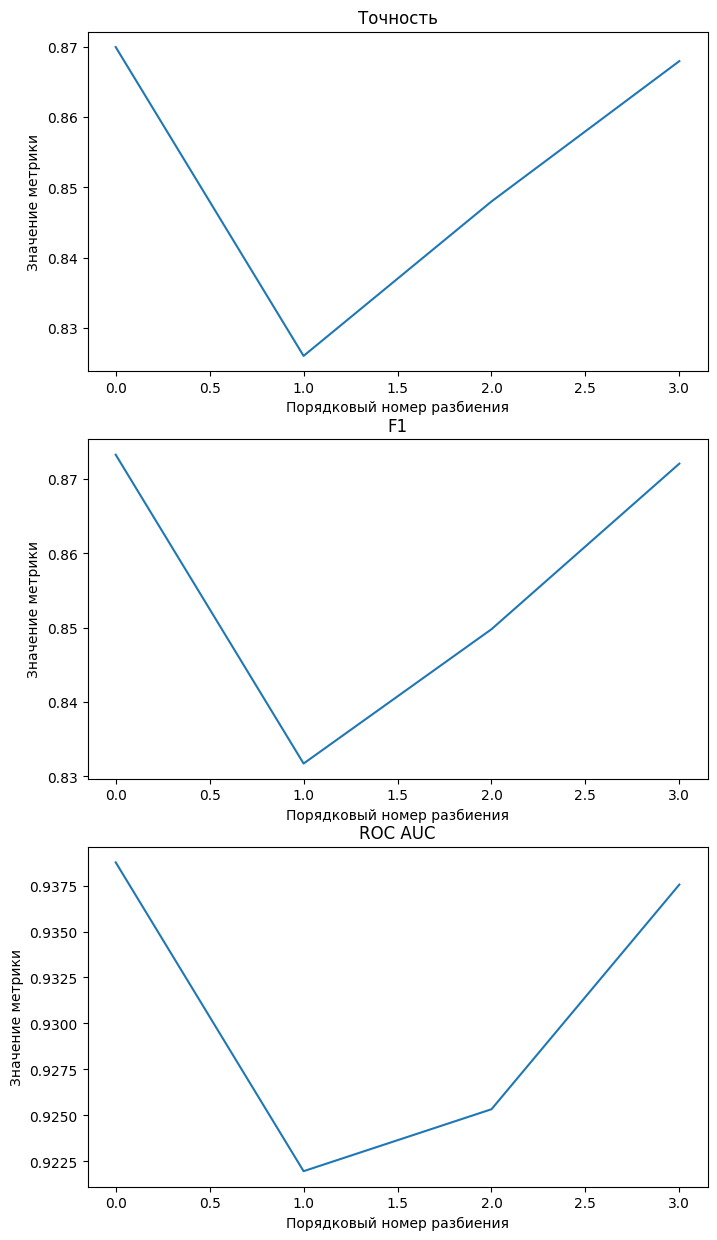

In [66]:
crossScores(vectorized_data_bert, estimator)
plt.savefig("plots/perceptronMetricsBert.pdf", format="pdf")